In [1]:
#meta 1/17/2020 Kaggle Cassava Data
#fast.ai 2020 study group Kaggle Competition
#src https://www.kaggle.com/c/cassava-leaf-disease-classification
#prev competition src https://www.kaggle.com/c/cassava-disease
#references https://arxiv.org/pdf/1908.02900.pdf

#input: kaggle files - images, csv with 5 cats
#output: data artifacts for next step 2-model
#pwd: /kaggle/working
#based on my-kaggle-cassava-1-model.ipynb

#history
#1/4/2021 DATA - IMBALANCED DS -> STRATIFIED VALIDATION SET
#      dataprep delta: Stratified data split
#      src https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
#      dataprep delta: add df_train['is_valid'] column needed for ColSplitter()
#      src https://docs.fast.ai/tutorial.datablock.html

#1/17/2021 DATA MODULE, ORIGINAL TRAIN DS AND OVERSAMPLED TRAIN DS
#      With Stratified data split
#      Imbalanced dataset -> oversample
#      Export train datasets. $param

#here 2/7/2020 DATA MODULE, ORIGINAL TRAIN DS AND OVERSAMPLED TRAIN DS
#      With Stratified data split
#      Imbalanced dataset -> manual oversample
#      2 versions: full and mini for rapid iteration (10%) $param


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import os
import time #to track performance time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#stratified split
from sklearn.model_selection import StratifiedShuffleSplit

#modeling
from fastai.vision.all import *


# Input data files are available in the read-only "../input/" directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#--constants and variables
SEED = 24
MINI_FLG = 0 #$param
MINI_DS_SIZE = 0.1
VALID_DS_SIZE = 0.2

path = Path('../input/cassava-leaf-disease-classification')

#--functions
#define label lookup 
def lookup_label(image_id): return int(df_train[df_train['image_id']== image_id]['label'])

#test function
#lookup_label('100042118.jpg')

# Cassava Data
21397 train images and 1 test image

## 0. Load Data
- input images
- output labels
- train dataset

In [4]:
path.ls()

(#7) [Path('../input/cassava-leaf-disease-classification/train_tfrecords'),Path('../input/cassava-leaf-disease-classification/sample_submission.csv'),Path('../input/cassava-leaf-disease-classification/test_tfrecords'),Path('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'),Path('../input/cassava-leaf-disease-classification/train_images'),Path('../input/cassava-leaf-disease-classification/train.csv'),Path('../input/cassava-leaf-disease-classification/test_images')]

In [5]:
(path/'train_images').ls(), (path/'test_images').ls()

((#21397) [Path('../input/cassava-leaf-disease-classification/train_images/1235188286.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/1215607589.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/478554372.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/2763304605.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/2826122413.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/111117998.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/231268038.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/4201965605.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/3224710052.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/1290729293.jpg')...],
 (#1) [Path('../input/cassava-leaf-disease-classification/test_images/2216849948.jpg')])

In [6]:
#load train/test images
#train_img = get_image_files(path/'train_images')
#test_img = get_image_files(path/'test_images')

#print("Number of files: ", (len(train_img), len(test_img)))

In [7]:
#labels
with open((path/'label_num_to_disease_map.json')) as json_file:
    target_map = json.load(json_file)
    
print(target_map)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [8]:
#train Dataset
df_train = pd.read_csv(path/'train.csv')

print('train data\n', df_train.shape)
display(df_train.head())


train data
 (21397, 2)


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


## 1. Prep Data
### 1.1 Full or Mini dataset

TRAIN: [20562  3655 13241 ...  2664  2076  4573] VALID: [14727 12496 11627 ...  9559 12465  1439]


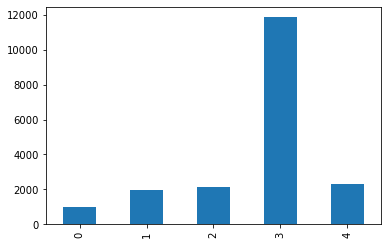

In [9]:
#train mini subsample for rapid iteration
if MINI_FLG:
    #stratified subsample
    X_mini = df_train['image_id']
    y_mini = df_train['label']
    sss_mini = StratifiedShuffleSplit(n_splits=1, test_size=MINI_DS_SIZE, random_state=SEED)
    
    for train_idx_mini, valid_idx_mini in sss_mini.split(X_mini, y_mini):
        print("TRAIN:", train_idx_mini, "VALID:", valid_idx_mini)
        y_train_mini, y_valid_mini = y_mini[train_idx_mini], y_mini[valid_idx_mini]

    y_train_mini.value_counts().sort_index()
    y_train_mini.value_counts().sort_index().plot(kind='bar');
    

In [10]:
#train subsample
if MINI_FLG:
    #update df_train with train index 
    df_train = df_train.loc[df_train.index.isin(valid_idx_mini)].reset_index()
    print(df_train.shape)
    print(df_train.head())
    

(2140, 3)
   index        image_id  label
0     19  1003987001.jpg      3
1     23  1004672608.jpg      3
2     24   100472565.jpg      2
3     27  1005138819.jpg      3
4     42  1008244905.jpg      1


0     109
1     219
2     238
3    1316
4     258
Name: label, dtype: int64


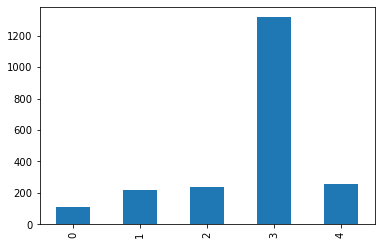

In [11]:
print(df_train['label'].value_counts().sort_index())
df_train['label'].value_counts().sort_index().plot(kind='bar');

### 1.2 Stratified Split
Stratified shuffle split to create a proportional validation set

In [12]:
X = df_train['image_id']
y = df_train['label']
sss = StratifiedShuffleSplit(n_splits=1, test_size=VALID_DS_SIZE, random_state=SEED)
print(sss.get_n_splits(X, y))

1


In [13]:
df_train.head()

,index,image_id,label
0,19,1003987001.jpg,3
1,23,1004672608.jpg,3
2,24,100472565.jpg,2
3,27,1005138819.jpg,3
4,42,1008244905.jpg,1


In [14]:
for train_idx, valid_idx in sss.split(X, y):
    print("TRAIN:", train_idx, "\nVALID:", valid_idx)
    y_train, y_valid = y[train_idx], y[valid_idx]

y_train.value_counts().sort_index(), y_valid.value_counts().sort_index()

TRAIN: [ 501 1468 1853 ...  174  776  219] 
VALID: [1916 1822  971 2030  803 1979 2029  565 1165   19 1399 1518  352 1087
  587 1967   47 2050 1806  335 1185  688  416 1283 1384 1285  431  823
  899  374 1881  130  497  840 1025  132  260  572  592 1406 1589   91
   79  190 1256 1869 1073 1787  310  651 1267  541  902  498   13 1736
  255 1431  494 1445  669  957 1489 1253  634 2102  346 1240  958 1177
 1849 1548 1689 1788  834  412  718 2090  148 2116 2019  998 1145  676
  141  249  180 1845 1729  385 1776 1950 2020  253 1963  918 1771  680
  539 1159  311  257 1301  970 1294 1741  742 1088 1650  437 1595 1335
  196  920  536  313 1628  453 1028 1401 1999 1059 1032  288  709  724
 2036 1131  509  973 1243  142   49  197  747 1534 1592 1448 1710   64
  232 1398  507 2009  605  981  121  295  937 1233  762 1647  353  337
  815 1514 1162 1642  225 1804 1262 1029 1155  283 1509  405   50  871
  852 1169 1292  649  114 1452  615 1720 1126 2133 2005 1795  119  969
  309  997 2040  940  300 

(0      87
 1     175
 2     190
 3    1053
 4     207
 Name: label, dtype: int64,
 0     22
 1     44
 2     48
 3    263
 4     51
 Name: label, dtype: int64)

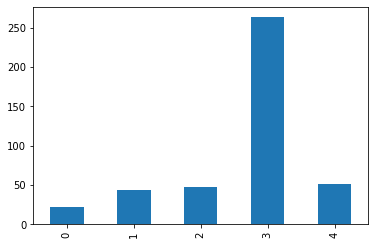

In [15]:
#vis validation ds distribution
y_valid.value_counts().sort_index().plot(kind = 'bar');

In [16]:
#update df_train with valid index 
df_train['is_valid'] = 0
df_train.loc[df_train.index.isin(valid_idx), 'is_valid'] = 1
df_train['is_valid'].value_counts()
        

0    1712
1     428
Name: is_valid, dtype: int64

In [17]:
#export data
if MINI_FLG:
    torch.save(df_train, 'df_train_mini.pkl')
else:
    torch.save(df_train, 'df_train.pkl')

## 1.1 Imbalanced Dataset
balance it a little -> oversample minority classes

In [18]:
if MINI_FLG:
    df_train.reset_index(inplace=True, drop=True)
else:
    df_train.reset_index(inplace=True)
df_train.head()

,index,image_id,label,is_valid
0,19,1003987001.jpg,3,1
1,23,1004672608.jpg,3,0
2,24,100472565.jpg,2,0
3,27,1005138819.jpg,3,0
4,42,1008244905.jpg,1,0


In [19]:
df_train_xtra = df_train[(df_train['is_valid']==0) & (df_train['label']!=3)]
df_train_xtra.reset_index(inplace=True, drop=True)
print(df_train_xtra.shape)
df_train_xtra.head()

(659, 4)


,index,image_id,label,is_valid
0,24,100472565.jpg,2,0
1,42,1008244905.jpg,1,0
2,70,1011909285.jpg,4,0
3,79,1012902365.jpg,4,0
4,84,1014359226.jpg,2,0


In [20]:
df_train_os = pd.concat([df_train, df_train_xtra])
df_train_os.reset_index(inplace=True, drop=True)
print(df_train_os.shape)
df_train_os.tail()

(2799, 4)


,index,image_id,label,is_valid
2794,21305,980448273.jpg,4,0
2795,21338,986999751.jpg,0,0
2796,21361,992748624.jpg,1,0
2797,21371,994727955.jpg,1,0
2798,21396,999998473.jpg,4,0


0     196
1     394
2     428
3    1316
4     465
Name: label, dtype: int64


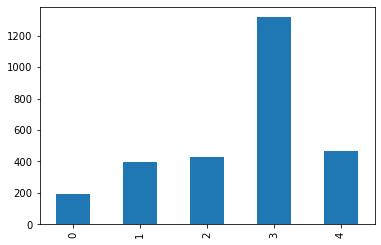

In [21]:
#vis train ds oversampled distribution, train + validation part
print(df_train_os['label'].value_counts().sort_index())
df_train_os['label'].value_counts().sort_index().plot(kind = 'bar');

0     174
1     350
2     380
3    1053
4     414
Name: label, dtype: int64


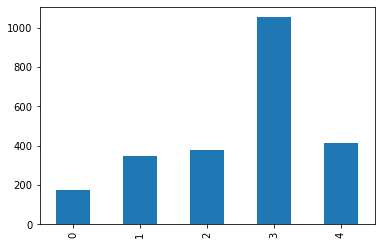

In [22]:
#vis train ds oversampled distribution, train part only
print(df_train_os.loc[df_train_os['is_valid']==0,'label'].value_counts().sort_index())
df_train_os.loc[df_train_os['is_valid']==0,'label'].value_counts().sort_index().plot(kind = 'bar');

0     22
1     44
2     48
3    263
4     51
Name: label, dtype: int64


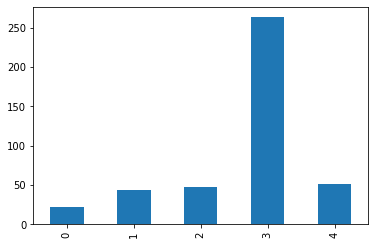

In [23]:
#vis train ds oversampled distribution, validation part only
print(df_train_os.loc[df_train_os['is_valid']==1,'label'].value_counts().sort_index())
df_train_os.loc[df_train_os['is_valid']==1,'label'].value_counts().sort_index().plot(kind = 'bar');

In [24]:
#export data
if MINI_FLG:
    torch.save(df_train_os, 'df_train_os_mini.pkl')
else:
    torch.save(df_train_os, 'df_train_os.pkl')